In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import seaborn as sns
import math
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_white
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import normaltest
from scipy.stats import chi2
import statsmodels.stats.api as sms
from scipy.stats import kstest, norm
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

In [2]:
periods='bts_truck_d11	Monthly,bts_vmt	Monthly,bts_vmt_d11	Monthly,bts_tsi_freight	Monthly,bts_manuf	Monthly,bts_inv_to_sales	Monthly,fred_ppi_gftld	Monthly,fred_ppi_sftld	Monthly,fred_ppi_fdfg	Monthly,fred_ppi_ids4	Monthly,fred_ppi_ids3	Monthly,fred_ett_sa	Monthly,fred_ett_nsa	Monthly,fred_etw_nsa	Monthly,fred_etw_sa	Monthly,bls_NonFarmEmployment	Monthly,bea_w_m_WagesAndSalaries	Monthly,bea_w_m_PrivateIndustries	Monthly,bea_w_m_Goods-ProducingIndustries	Monthly,bea_w_m_Manufacturing	Monthly,bea_w_m_Services-ProducingIndustries	Monthly,bea_w_m_TradeTransportationAndUtilities	Monthly,bea_w_m_OtherServices-ProducingIndustries	Monthly,bea_w_m_Government	Monthly,bea_WagesSalaries_TT	Annual,bea_GDP_TT	Annual,bea_Taxes_TT	Annual,usda_tm_tons_FruitAndVegetables	Annual,usda_tm_tons_Grains	Annual,usda_tm_tons_Livestock	Annual,usda_tm_tons_Meat	Annual,usda_tm_tons_Milk	Annual,usda_tm_tons_Poultry	Annual,usda_tm_tons_Total	Annual,usda_tm_value_FruitAndVegetables	Annual,usda_tm_value_Grains	Annual,usda_tm_value_Livestock	Annual,usda_tm_value_Meat	Annual,usda_tm_value_Milk	Annual,usda_tm_value_Poultry	Annual,usda_tm_value_Total	Annual'
periods=periods.replace('	',':')
periods=periods.replace('Monthly',"'Month'")
periods=periods.replace('Annual',"'Annual'")

periods={'bts_truck_d11':'Month','bts_vmt':'Month','bts_vmt_d11':'Month','bts_tsi_freight':'Month','bts_manuf':'Month','bts_inv_to_sales':'Month','fred_ppi_gftld':'Month','fred_ppi_sftld':'Month','fred_ppi_fdfg':'Month','fred_ppi_ids4':'Month','fred_ppi_ids3':'Month','fred_ett_sa':'Month','fred_ett_nsa':'Month','fred_etw_nsa':'Month','fred_etw_sa':'Month','bls_NonFarmEmployment':'Month',
'bea_w_m_WagesAndSalaries':'Month','bea_w_m_PrivateIndustries':'Month','bea_w_m_Goods-ProducingIndustries':'Month','bea_w_m_Manufacturing':'Month',
'bea_w_m_Services-ProducingIndustries':'Month','bea_w_m_TradeTransportationAndUtilities':'Month','bea_w_m_OtherServices-ProducingIndustries':'Month','bea_w_m_Government':'Month',
'bea_WagesSalaries_TT':'Annual','bea_GDP_TT':'Annual','bea_Taxes_TT':'Annual','usda_tm_tons_FruitAndVegetables':'Annual',
'usda_tm_tons_Grains':'Annual','usda_tm_tons_Livestock':'Annual','usda_tm_tons_Meat':'Annual','usda_tm_tons_Milk':'Annual','usda_tm_tons_Poultry':'Annual','usda_tm_tons_Total':'Annual',
'usda_tm_value_FruitAndVegetables':'Annual','usda_tm_value_Grains':'Annual','usda_tm_value_Livestock':'Annual','usda_tm_value_Meat':'Annual',
'usda_tm_value_Milk':'Annual','usda_tm_value_Poultry':'Annual','usda_tm_value_Total':'Annual'}

weekly=['eia_diesel_U.S.', 'eia_diesel_RockyMountain', 'eia_diesel_Midwest', 'eia_diesel_WestCoast', 'eia_diesel_EastCoast', 'eia_diesel_GulfCoast', 'eia_gasoline_WestCoast', 'eia_gasoline_Midwest', 'eia_gasoline_U.S.', 'eia_gasoline_RockyMountain', 'eia_gasoline_GulfCoast', 'eia_gasoline_EastCoast', 'usda_gtci_truck', 'usda_gtci_unit_train', 'usda_gtci_shuttle_train', 'usda_gtci_barge', 'usda_gtci_gulf_vessel', 'usda_gtci_pacific_vessel']
month=['bts_truck_d11', 'bts_vmt', 'bts_vmt_d11', 'bts_tsi_freight', 'bts_manuf', 'bts_inv_to_sales', 'fred_ppi_gftld', 'fred_ppi_sftld', 'fred_ppi_fdfg', 'fred_ppi_ids4', 'fred_ppi_ids3', 'fred_ett_sa', 'fred_ett_nsa', 'fred_etw_nsa', 'fred_etw_sa', 'bls_NonFarmEmployment', 'bea_w_m_WagesAndSalaries', 'bea_w_m_PrivateIndustries', 'bea_w_m_Goods-ProducingIndustries', 'bea_w_m_Manufacturing', 'bea_w_m_Services-ProducingIndustries', 'bea_w_m_TradeTransportationAndUtilities', 'bea_w_m_OtherServices-ProducingIndustries', 'bea_w_m_Government']
annual=['bea_WagesSalaries_TT', 'bea_GDP_TT', 'bea_Taxes_TT', 'usda_tm_tons_FruitAndVegetables', 'usda_tm_tons_Grains', 'usda_tm_tons_Livestock', 'usda_tm_tons_Meat', 'usda_tm_tons_Milk', 'usda_tm_tons_Poultry', 'usda_tm_tons_Total', 'usda_tm_value_FruitAndVegetables', 'usda_tm_value_Grains', 'usda_tm_value_Livestock', 'usda_tm_value_Meat', 'usda_tm_value_Milk', 'usda_tm_value_Poultry', 'usda_tm_value_Total']

In [112]:
dfweekly=pd.read_csv("ext_metrics_weekly.csv").sort_values(by=['date'])
dfmonthly=pd.read_csv("ext_metrics_monthly.csv").sort_values(by=['date'])
dfannual=pd.read_csv("ext_metrics_annual.csv")

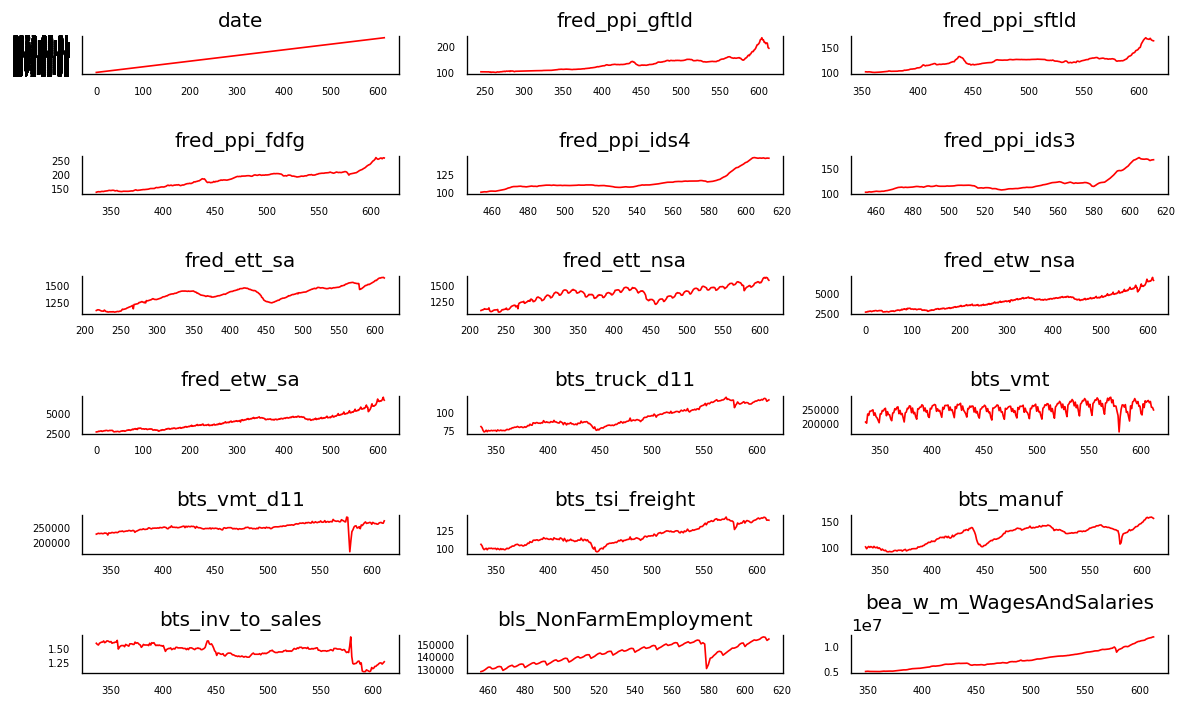

In [4]:
fig, axes = plt.subplots(nrows=6, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = dfmonthly[dfmonthly.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(dfmonthly.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

#### 1. Creating the df between independent and dependent variable

In [5]:
def sample_dates(n,df):
    
    """
    
    Groups the weekly data depending on the indicators' temporality into monthly or annual data.
    
    Args:
        n (Integer): Temporality needed: 1 if month, 2 if year.
        df (Dataframe): Weekly data
        
    Returns:
        df (Dataframe): Weekly information grouped per month or year.
        
    """
    
    #It is necessary to set the index to "date" to use the "resample code"
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    
    if n==1:
        
        #Groups the data for each month of each year and calculates the mean
        df = df.resample('M').mean()
        end_dates = df.index
        new_dates = []
        
        #Matches the order of the weekly "date" column as is presented in the column "date" of the monthly_data dataframe, 
        #e.g. "25-01-2007" to "01-01-2007" to support the next merge process
        for k in end_dates:
            k=datetime.strptime(str(k), "%Y-%m-%d %H:%M:%S")
            k=k.strftime("%Y-%m-%d")
            date = datetime.strptime(k, "%Y-%m-%d")
            first_day = datetime(date.year, date.month, 1)
            new_dates.append(first_day.strftime("%Y-%m-%d"))
        
        #Creates a date columns that is used after to group the weekly and monthly information
        df['date']=new_dates
    
    if n==2:
        
        #Groups the data for each year and calculates the mean
        df =df.resample('Y').mean()
        end_dates = df.index
        new_dates = []
        
        #Takes the year of each observation
        for k in end_dates:
            k=datetime.strptime(str(k), '%Y-%m-%d %H:%M:%S')
            k=k.year
            new_dates.append(k)
            
        #Creates a date columns that is used after to group the weekly and annual information
        df['date']=new_dates
        
    return df

In [6]:
def merge_date(indicator,n,dfx,dfy):
    
    """
    
    Joins the weekly data with the indicator of analysis.
    
    Args:
        Indicator (String): Indicator whose VAR Model is being created.
        n (Integer): Temporality needed: 1 if month, 2 if year.
        dfx (Dataframe): Weekly data
        dfy (Dataframe): Monthly or annual data
        
    Returns:
        dfx (Dataframe): Dataframe that contains the independent and dependent indicators.
    
    """
    
    dfx=sample_dates(n,dfx) #Calls the "sample_dates" function
    dfx.reset_index(drop=True, inplace=True)
    dfx=dfx.merge(dfy[['date',indicator]].dropna(), how='left', on='date').sort_values(by=['date'])
    dfx=dfx.dropna().reset_index(drop=True, inplace=False)
    dfx=dfx.drop(['date'],axis=1)
    
    return dfx

#### 2. Stationarity

In [7]:
def stationarity(df):
    
    """
    
    Test the stationarity of the timeseries contained in the dataframe and if it is false, then differentiates the dataframe
    until all the timeseries are stationary.
    
    Args:
        df (Dataframe): Dataframe that contains both the dependent and independent indicators.
   
    Returns:
        df (Dataframe): Dataframe that contains the independent and dependent indicators but stationaries.
        d (Integer): Number of times that the dataframe was differentiated.
    
    """
    
    st=1
    d=0
    
    while st>0:
        columns=[]
        for col in df.columns.tolist():
            
            #ADF Test for stationarity:
            #H0: The timeseries is not stationary
            #H1: The timeseries is stationary
            
            r=adfuller(df[col], autolag='AIC')
            output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
            p_value = output['pvalue']
            if p_value>=0.05:
                columns.append(col) #We keep the column that makes necessary the differentiation process
                
        st=len(columns)
        if st>0:
            d=d+1
            if d==3: #Notice that we consider inappropriate to differentiate the dataframe more than 2 times
                print("WARNING: The next variable(s) aren't stationary after a second differentation process:", columns)
            df=df.diff()
            df=df.dropna()
            
    return d,df

#### 3. Causality

In [8]:
def granger_matrix(indicator,df):
    
    """
    
    Filters the columns that are correlated to the dependent indicator.
    
    Args:
        indicator (String): Indicator whose VAR Model is being created.
        df (Dataframe): Dataframe that contains the independent and dependent indicators but stationaries.
   
    Returns:
        pv (Float): P-Value used to get the 7 columns minimum.
        cols (List): Weekly indicators that are proved to be correlated with the dependent indicator.
    
    """
    
    maxlag= 6
    independent= df.columns.tolist()[:-1]
    ci=[0.05,0.1,0.15,0.2,0.25]
    test='ssr_chi2test'
    
    #H0: The variable X is not correlated to Y
    #H1: The variable X is correlated to Y
    
    for pv in ci:
        cols=[]
        
        for k in independent:
            results = grangercausalitytests(df[[k, indicator]], maxlag=6)
            p_values = [round(results[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            if min_p_value<pv:
                cols.append(k) #Keeps the variables that cause Y
                
        if len(cols)>=7: #If the number of variables required is achieved, the stops the cycle.
            break
            
    return pv,cols

#### 4. Traninig, testing and varmodel

In [9]:
def split(df,lags):
    
    """
    
    Splits the dataframe into training and testing.
    
    Args:
        df (Dataframe): Dataframe that contains the independent and dependent indicators but stationaries.
        lags (Integer): Number of lags used to create the VAR model.
   
    Returns:
        dftrain (Dataframe): Dataframe used to create the VAR Model.
        dftest (Dataframe): Dataframe used to prove the accuracy of the model selected.
    
    """
    
    dftrain=df[:-lags]
    dftest=df[-lags:]
    
    return dftrain, dftest

In [68]:
def create_model(indicator,df):
    
    """
    
    Creates and selects the VAR model depending on the AIC statistic and the errors' assumptions tests.
    
    Args:
        indicator (String): Indicator whose VAR Model is being created.
        df (Dataframe): Dataframe that contains the independent and dependent indicators but stationaries.
   
    Returns:
        
        warning (String): Description of the errors' assumptions tests.
        mod0 (Dataframe): Description of all the variables used in the model, with their coefficients, names and lags.
        var_si (Dataframe): Description of just the significative variables in the model, with their coefficients, 
                            names and lags.
        fit (VAR Model): The VAR Model selected to predict the dependent indicator.
        ar (Integer): Number of lags selected to create the VAR Model.
        dftraining (Dataframe): Final dataframe used to create the VAR Model.
        dftesting (Dataframe): Final dataframe to prove the accuracy of the model selected.
        
    """
    
    mod0=pd.DataFrame(columns=['Indicator','Frequency','Coefficients','Lags','Variable'])
    a=1 #To test the errors' assumptions
    warning=" the variables that cause it aren't significant in the model" #A default warning
    
    #*Calls the "split" function. We split it into 6 lags, because that's how we obtain the AIC Value of each VAR Model
    #from 1 lag to 6 lags.
    
    dftraining, dftesting = split(df,6) #*
    model = VAR(dftraining)
    
    #Then, it sorts in descending order by AIC the number of lags required. So we focused on test the lag that gives us
    #the best AIC to the least AIC.
    
    lag_selection = pd.DataFrame(model.select_order(maxlags=6).summary(),columns=['Lags','AIC','BIC','FPE','HQIC'])
    lag_selection = lag_selection[2:].reset_index(drop=True).astype(str)
    lag_selection['AIC']=lag_selection['AIC'].apply(lambda x: float(x) if "*" not in x else float(x[:-1]))
    best_aic=list(lag_selection.sort_values(['AIC'])['Lags'].astype(int))
    best=0 #This is an iterative element, that calls the best lag from the "best_aic" list.
        
    while a>0: #The cycle stops when the all the errors are approved.
        
        z=0
        ar=best_aic[best]
        
        #Creates the VAR Model for the best aic tested
        dftraining, dftesting = split(df,ar) 
        fit = VAR(dftraining).fit(ar)
        pvalues = fit.pvalues
        lags=pvalues.index
        variables_sign=[]
        i=0

        #Collects the significative indicators
        for p in pvalues[indicator]:
            if p<0.05:
                variables_sign.append(lags[i])
            i=i+1
        
        var_si=fit.params.loc[variables_sign][[indicator]]
        var_si['variable']=var_si.index
        var_si['variable']=var_si['variable'].apply(lambda x: x[3:])
        variables_sign=list(var_si['variable'].unique())
        
        if 'st' in variables_sign:
            variables_sign.remove('st')
            
        if indicator in variables_sign:
            variables_sign.remove(indicator)
        
        #Filters the df training just with the significative variables and the indicator predicted.
        dftraining=dftraining[variables_sign+[indicator]]
        
        #When there aren't enough significative variables, then the number of lags to test changes and if we are in the last
        #number of lags, then the cycle stops.
        
        if dftraining.shape[1]<=1:
            if best==5:
                z=(" But the model doesn't work because:"+warning)
                break
            best=best+1
            continue

        #We create again the VAR Model with the number of lags with the significative variables and the lags tested.
        fit = VAR(dftraining).fit(ar)
        
        #Now the errors' assumptions are tested for the model.
        a,warning=assumptions(dftraining,indicator,variables_sign,fit,ar)
        
        #If the model doesn't pass the assumptions, that means a>0, then the lag changes, and if we are in the last
        #number of lags, then the cycle stops.
        if a>0 and best==5:
            z=(" But the model doesn't work because:"+warning)
            break
        
        if a>0 and best<=4:
            best=best+1

    dftesting=dftesting[variables_sign+[indicator]]
    pvalues = fit.pvalues
    lags=pvalues.index
    variables_sign=[]
    i=0
    
    #We take the final significative variables of the model
    for p in pvalues[indicator]:
        if p<0.05:
            variables_sign.append(lags[i])
        i=i+1

    #And we put the results into the var_si and mod0 dataframes.
    var_si=fit.params.loc[variables_sign][[indicator]].rename(columns={indicator:'Coefficients'})
    mod0=fit.params[[indicator]].rename(columns={indicator:'Coefficients'})
    var_si=reportvar(var_si,indicator)
    mod0=reportvar(mod0,indicator)
    
    return warning, mod0, z, var_si, fit, ar, dftraining, dftesting

#### 5. Residuals assumptions

In [11]:
def assumptions(dftraining,indicator,varb,fit,maxlag):
    
    """
    
    Test the errors' assumptions for the VAR Model created.
    
    Args:
        dftraining (Dataframe): Dataframe used to create the VAR Model.
        indicator (String): Indicator whose VAR Model is being created.
        varb (List): Significative variables independent.
        fit (Model): VAR Model to test.
        maxlag (Integer): Number of lags to test.
        
    Returns:
    
        a (Integer): Number of tests that the residuals don't pass.
        warning (String): Description of the errors' assumptions tests.
        
    """
        
    a=0
    residuals=fit.resid[indicator]
    
    ci=[0.05,0.1,0.15,0.2,0.25]
    
    for pv in ci:
        
        warning=""
        
        #homocedasticity
        #H0: The residuals are homocedastic.
        #H1: The residuals aren't homocedastic.
        white_test = het_white(residuals,  sm.add_constant(dftraining[varb][:-maxlag]))
        if white_test[1]<0.05:
            warning=warning + " The residuals aren't homocedastic"
            a=a+1

        #normality test
        #H0: The residuals have a normal distribution.
        #H1: The residuals don't have a normal distribution.
        stat, p = shapiro(residuals)
        if p<0.05:
            stat, p = kstest(residuals, 'norm')
            if p<0.05:
                a=a+1
                warning = warning + " The residuals do not follow a normal distribution"

        #independency
        #H0: The residuals are independent.
        #H1: The residuals aren't independent.
        out = durbin_watson(residuals)
        if out < 1.5 and out >=2.5:
            a=a+1
            warning = warning + " The residuals aren't independent"
        
        warning = warning + " in none of the confidence levels."
        
        if a==0:
            warning = "The assumptions made about the residuals are verified with a confidence of " + str(1-pv) + "."
            break
        
    return a,warning

#### 6. Forecasting

In [114]:
def invert_transformation(indicator,diff,dftraining,dftesting,df_train_original, fit):

    """
    
    Predicts the testing values and takes out the differentiation process to present the value in the real scale.
    
    Args:
        indicator (String): Indicator whose VAR Model is being created.
        diff (Integer): Number of times that the dataframe was differentiated.
        dftraining (Dataframe): Dataframe with stationary values used to create the VAR Model.
        dftesting (Dataframe): Dataframe with stationary values used to test the VAR Model.
        dftrainoriginal (Dataframe): Dataframe with the training original values.
        fit (Model): VAR Model to test.
        
    Returns:
    
        prediction (Dataframe): Dataframe with the stationary and original testing values predicted by the model.
        
    """
    
    lag_order = fit.k_ar
    
    fc = fit.forecast(dftraining.values, steps=len(dftesting.index))
    prediction=pd.DataFrame(fc, index=dftesting.index, columns=dftraining.columns + '_d')[[indicator+'_d']]
    
    d=diff
    col = indicator
    if d==2:
        prediction[str(col)+'_d'] = (df_train_original[col].iloc[-1]-df_train_original[col].iloc[-2]) + prediction[str(col)+'_d'].cumsum()
        d=d-1
    if d==1:
        prediction[str(col)+'_forecast'] = df_train_original[col].iloc[-1] +prediction[str(col)+'_d'].cumsum()
        
    return prediction

#### 7. Forecast visual

In [13]:
def graphic(dfprediction,dftestoriginal):
    dfprediction[indicator+'_original']=dftestoriginal[indicator]
    dfprediction[indicator+'_forecast'].plot(legend=True)
    dfprediction[indicator+'_original'].plot(legend=True)
    plt.title(indicator + ": Forecast vs Actuals")
    plt.tight_layout();

#### 8. Forecasting new values

In [14]:
def new_forecast(d,df_original, fit):
    nobs=int(input("Periods: "))
    fc = fit.forecast_interval(df_original.values, nobs, alpha=0.05)
    variables=len(df_original.columns)
    forecast_k=pd.DataFrame()
    
    for i in range(0,3): #0 normal, 1 lowerci, 2 upperci, but with diff
        nparray=np.array([])
        for k in range(0,nobs): #number of forecast
            for j in range(variables):  #punctual observation
                nparray=np.append(nparray,fc[i][k][j])
        forecast_k[str(i)]=nparray
    
    ind=[]
    for i in range(0,nobs):
        x= (variables-1)+(variables*i)
        ind.append(x)

    forecast_k=forecast_k.loc[ind]
    col = indicator
    
    for l in forecast_k.columns: #0,1,2
        if d==2:
            forecast_k[str(l)+'f'] = (df_original[col].iloc[-1]-df_original[col].iloc[-2]) + forecast_k[l].cumsum()
            d=d-1
        if d==1:
            forecast_k[str(l)+'f'] = df_original[col].iloc[-1] + forecast_k[l].cumsum()
    
    dic={'0f':'mean','1f':'lower','2f':'upper'}
    forecast_k=forecast_k.rename(columns=dic)
    neworder = ['lower', 'mean', 'upper']
    forecast_k=forecast_k.reindex(columns=neworder).reset_index(drop=True,inplace=False)
    
    return forecast_k

In [15]:
def forecast_accuracy(forecast, actual):
    
    """
    
    Calculates the forecasting's error accuracy.
    
    Args:
        forecast (Dataframe): Indicator's testing values predicted by the model.
        actual (Dataframe): Indicator's original testing values.
        
    Returns:
    
        mape (float): Mean Absolute Percentage Error
        mae (float): Mean Absolute Error
        rmse (float): Root mean Square Error
        
    """
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return mape, mae, rmse

#### 10. Model's results

In [16]:
def reportvar(df,indicator):
    
    """
    
    Fills the dataframes displayed to show the VAR Model results.
    
    Args:
        df (Dataframe): Dataframe used to display the results.
        indicator (String): Indicator whose VAR model is being created.
        
    Returns:
    
        df (Dataframe): Dataframe with the variables required and their coefficients, names and frequency.
        
    """
    
    df['Variable']=df.index
    df['Lags']= [i[:2] if i!='const' else 'const' for i in df['Variable']]
    df['Variable']=[i[3:] if i!='const' else 'const' for i in df['Variable']]
    df['Indicator']=indicator
    df['Frequency']=df['Indicator'].replace(periods)
    
    return df

#### 11. Testing functions

In [124]:
def month_withoutgranger(indicator,dfweekly,dfmonthly):
        
    """
    
    Combines all the previous functions and generate the summaries of the metrics and results of the model selected from
    a given indicator, but without using the granger matrix for causality between indicators.

    Args:
        indicator (String): Indicator whose VAR model is being created.
        dfweekly (Dataframe): Raw dataframe with the weekly metrics (with nan values).
        dfmonthly (Dataframe): Raw dataframe with the monthly metrics (with nan values).
        
    Returns:
        mape1 (Float): Mean Absolute Percentage Error
        report (Dataframe): Explains the confidence levels used to test the model, its metrics and if it was possible
                            to create it or not.
        model_created (Dataframe): Dataframe with all the variables used in the model and their coefficients.
        var_sign (Dataframe): Dataframe with just the significative variables of each model created and their coefficients.
        
    """
    var_sign=pd.DataFrame(columns=['Indicator','Frequency','Coefficients','Lags','Variable'])
    model_created=pd.DataFrame(columns=['Indicator','Frequency','Coefficients','Lags','Variable'])
    equis=dfweekly.copy()
    result_display=""
    resultt=[]
    indc=[]
    
    #Statistics
    mape1=0
    mape=[]
    mae=[]
    rmse=[]
    bic=[]
    aic=[]
    hqic=[]
    fpe=[]
    
    if indicator not in ['date','state_id']:
        indc.append(indicator)
        
        n=1
        yes=dfmonthly.copy()
        equis=merge_date(indicator,n,equis,yes)
        dforiginal=equis.copy()

        diff, equis=stationarity(equis)

        if diff>2:
            resultt.append("The model could be inappropiate for this indicator because of lack of stationarity")
            mape.append('')
            mae.append('')
            rmse.append('')
            bic.append('')
            aic.append('')
            hqic.append('')
            fpe.append('')

        disp, mod01, z, var_si, fit, ar, dftraining, dftesting = create_model(indicator,equis)
        
        if z!=0:
            resultt.append(result_display + z)
            mape.append('')
            mae.append('')
            rmse.append('')
            bic.append('')
            aic.append('')
            hqic.append('')
            fpe.append('')
            
        if z==0:
            result_display = result_display + " " + disp + " The number of lags used is " + str(ar) + "."
        
            var_sign=pd.concat([var_sign,var_si], join='inner', ignore_index=True)
            model_created=pd.concat([model_created,mod01], join='inner', ignore_index=True)

            dforiginal=dforiginal[dftesting.columns.tolist()]
            dftrain, dftest= split(dforiginal, ar) 

            resultt.append(result_display)
            predictiontesting=invert_transformation(indicator,diff,dftraining,dftesting,dftrain,fit)
            mape1, mae1, rmse1 = forecast_accuracy(predictiontesting[indicator+'_forecast'],dftest[indicator])

            bic.append(fit.bic)
            aic.append(fit.aic)
            mape.append(mape1)
            mae.append(mae1)
            rmse.append(rmse1)
            hqic.append(fit.hqic)
            fpe.append(fit.fpe)

    report=pd.DataFrame({'Indicator':indc,'Result':resultt, 'mape':mape,'mae':mae,'rmse':rmse,'bic':bic,'aic':aic,
                        'hqic':hqic,'fpe':fpe})
    
    return mape1,report,model_created,var_sign

In [125]:
def month_granger(indicator,dfweekly,dfmonthly):
        
    """
    
    Combines all the previous functions and generate the summaries of the metrics and results of the model selected from
    a given indicator, but using the granger matrix for causality between indicators.
    
    Args:
        indicator (String): Indicator whose VAR model is being created.
        dfweekly (Dataframe): Raw dataframe with the weekly metrics (with nan values).
        dfmonthly (Dataframe): Raw dataframe with the monthly metrics (with nan values).
        
    Returns:
        mape1 (Float): Mean Absolute Percentage Error
        report (Dataframe): Explains the confidence levels used to test the model, its metrics and if it was possible
                            to create it or not.
        model_created (Dataframe): Dataframe with all the variables used in the model and their coefficients.
        var_sign (Dataframe): Dataframe with just the significative variables of each model created and their coefficients.
        
    """
    var_sign=pd.DataFrame(columns=['Indicator','Frequency','Coefficients','Lags','Variable'])
    model_created=pd.DataFrame(columns=['Indicator','Frequency','Coefficients','Lags','Variable'])
    equis=dfweekly.copy()
    result_display=""
    resultt=[]
    indc=[]
    
    #Statistics
    mape1=0
    mape=[]
    mae=[]
    rmse=[]
    bic=[]
    aic=[]
    hqic=[]
    fpe=[]
    
    if indicator not in ['date','state_id']:
        indc.append(indicator)
        
        n=1
        yes=dfmonthly.copy()
        equis=merge_date(indicator,n,equis,yes)
        dforiginal=equis.copy()

        diff, equis=stationarity(equis)

        if diff>2:
            resultt.append("The model could be inappropiate for this indicator because of lack of stationarity")
            mape.append('')
            mae.append('')
            rmse.append('')
            bic.append('')
            aic.append('')
            hqic.append('')
            fpe.append('')
        
        if diff<=2:
            
            ci,cols=granger_matrix(indicator,equis)

            if len(cols)>6:
                result_display = "Variables that significantly cause it were found with a confidence of " + str(1-ci) + "."
                equis=equis[cols+[indicator]]

            if len(cols)<=6:
                result_display = "There aren't variables that significantly cause it, still we create the model."

            disp, mod01, z, var_si, fit, ar, dftraining, dftesting = create_model(indicator,equis)
            
            if z!=0:
                resultt.append(result_display + z)
                mape.append('')
                mae.append('')
                rmse.append('')
                bic.append('')
                aic.append('')
                hqic.append('')
                fpe.append('')

            if z==0:
                result_display = result_display + " " + disp + " The number of lags used is " + str(ar) + "."

                dforiginal=dforiginal[dftesting.columns.tolist()]
                dftrain, dftest= split(dforiginal, ar) 

                var_sign=pd.concat([var_sign,var_si], join='inner', ignore_index=True)
                model_created=pd.concat([model_created,mod01], join='inner', ignore_index=True)

                resultt.append(result_display)
                predictiontesting=invert_transformation(indicator,diff,dftraining,dftesting,dftrain,fit)
                mape1, mae1, rmse1 = forecast_accuracy(predictiontesting[indicator+'_forecast'],dftest[indicator])

                bic.append(fit.bic)
                aic.append(fit.aic)
                mape.append(mape1)
                mae.append(mae1)
                rmse.append(rmse1)
                hqic.append(fit.hqic)
                fpe.append(fit.fpe)

    report=pd.DataFrame({'Indicator':indc,'Result':resultt, 'mape':mape,'mae':mae,'rmse':rmse,'bic':bic,'aic':aic,
                        'hqic':hqic,'fpe':fpe})
    
    return mape1,report,model_created,var_sign

In [126]:
def summary_var(dfweekly,dfmonthly):
    
    """
    
    This functions decide which performance is better, if using the granger matrix or not, for each indicator given. Also, joins the results of each
    model created.
    
    Args:
        indicator (String): Indicator whose VAR model is being created.
        dfweekly (Dataframe): Raw dataframe with the weekly metrics (with nan values).
        dfmonthly (Dataframe): Raw dataframe with the monthly metrics (with nan values).
        
    Returns:
        mape1 (Float): Mean Absolute Percentage Error
        report (Dataframe): Explains the confidence levels used to test the model, its metrics and if it was possible
                            to create it or not.
        model_created (Dataframe): Dataframe with all the variables used in the model and their coefficients.
        var_sign (Dataframe): Dataframe with just the significative variables of each model created and their coefficients.
        
    """
        

    report=pd.DataFrame(columns=['Indicator','Result','mape','mae','rmse','bic','aic','hqic','fpe'])
    var_sign=pd.DataFrame(columns=['Indicator','Frequency','Coefficients','Lags','Variable'])
    model_created=pd.DataFrame(columns=['Indicator','Frequency','Coefficients','Lags','Variable'])
    granger=[]
    
    for indicator in dfmonthly.columns:
        
        if indicator not in ['date','state_id']:
        
            print("The indicator is",indicator)

            mape1,report1,model_created1,var_sign1=month_granger(indicator,dfweekly,dfmonthly)
            mape2,report2,model_created2,var_sign2=month_withoutgranger(indicator,dfweekly,dfmonthly)

            if mape1==0 and mape2==0:
                report=pd.concat([report,report2], join='inner', ignore_index=True)
                granger.append("")
                continue

            print("El mape sin granger es:",mape2)
            print("El mape con granger es:",mape1)
            
            if (mape1<mape2 or mape2==0) and mape1!=0:
                var_sign=pd.concat([var_sign,var_sign1], join='inner', ignore_index=True)
                model_created=pd.concat([model_created,model_created1], join='inner', ignore_index=True)
                report=pd.concat([report,report1], join='inner', ignore_index=True)
                granger.append("Yes")

            else:
                if (mape2<=mape1 or mape1==0) and mape2!=0: #escoger sin granger
                    var_sign=pd.concat([var_sign,var_sign2], join='inner', ignore_index=True)
                    model_created=pd.concat([model_created,model_created2], join='inner', ignore_index=True)
                    report=pd.concat([report,report2], join='inner', ignore_index=True)
                    granger.append("Not")

    report['Use granger']=granger
        
    return var_sign,model_created,report

In [130]:
var,mod0,report=summary_var(dfweekly,dfmonthly)

The indicator is fred_ppi_gftld

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7977  , p=0.1816  , df_denom=186, df_num=1
ssr based chi2 test:   chi2=1.8267  , p=0.1765  , df=1
likelihood ratio test: chi2=1.8180  , p=0.1776  , df=1
parameter F test:         F=1.7977  , p=0.1816  , df_denom=186, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7511  , p=0.1765  , df_denom=183, df_num=2
ssr based chi2 test:   chi2=3.5978  , p=0.1655  , df=2
likelihood ratio test: chi2=3.5638  , p=0.1683  , df=2
parameter F test:         F=1.7511  , p=0.1765  , df_denom=183, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4303  , p=0.2355  , df_denom=180, df_num=3
ssr based chi2 test:   chi2=4.4578  , p=0.2161  , df=3
likelihood ratio test: chi2=4.4055  , p=0.2209  , df=3
parameter F test:         F=1.4303  , p=0.2355  , df_denom=180, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)

KeyboardInterrupt



In [137]:
workbook = Workbook()

sheet1 = workbook.create_sheet(title='summary_results')
sheet2 = workbook.create_sheet(title='metrics_complete_model')
sheet3 = workbook.create_sheet(title='significant_variables')

for row in dataframe_to_rows(report, index=False, header=True):
    sheet1.append(row)
    
for row in dataframe_to_rows(mod0, index=False, header=True):
    sheet2.append(row)
    
for row in dataframe_to_rows(var, index=False, header=True):
    sheet3.append(row)

workbook.remove(workbook['Sheet'])
workbook.save('VarModel_Summary.xlsx')